# 序列预测实例 - 北京空气污染预测（Sequence Prediction Example - Beijing Air Pollution Prediction）

In [ ]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv('./PRSA_data_2010.1.1-2014.12.31.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [ ]:
data[data['pm2.5'].isna()]

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43548,43549,2014,12,20,12,NaN,-18,0.0,1030.0,NW,244.97,0,0
43549,43550,2014,12,20,13,NaN,-19,1.0,1029.0,NW,249.89,0,0
43550,43551,2014,12,20,14,NaN,-20,1.0,1029.0,NW,257.04,0,0
43551,43552,2014,12,20,15,NaN,-20,2.0,1028.0,NW,262.85,0,0


In [ ]:
data = data.iloc[24:].copy()

In [ ]:
data.fillna(method='ffill', inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 24 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [ ]:
data.drop('No', axis=1, inplace=True)

In [ ]:
import datetime

In [ ]:
data['time'] = data.apply(lambda x: datetime.datetime(year=x['year'],
                                       month=x['month'],
                                       day=x['day'], 
                                       hour=x['hour']), 
                          axis=1)

In [ ]:
data.set_index('time', inplace=True)

In [ ]:
data.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

In [ ]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [ ]:
data.columns = ['pm2.5', 'dew', 'temp', 'press', 'cbwd', 'iws', 'snow', 'rain']

In [ ]:
data.cbwd.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [ ]:
data = data.join(pd.get_dummies(data.cbwd))

In [ ]:
del data['cbwd']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm2.5   43800 non-null  float64
 1   dew     43800 non-null  int64  
 2   temp    43800 non-null  float64
 3   press   43800 non-null  float64
 4   iws     43800 non-null  float64
 5   snow    43800 non-null  int64  
 6   rain    43800 non-null  int64  
 7   NE      43800 non-null  uint8  
 8   NW      43800 non-null  uint8  
 9   SE      43800 non-null  uint8  
 10  cv      43800 non-null  uint8  
dtypes: float64(4), int64(3), uint8(4)
memory usage: 4.1 MB


<AxesSubplot:xlabel='time'>

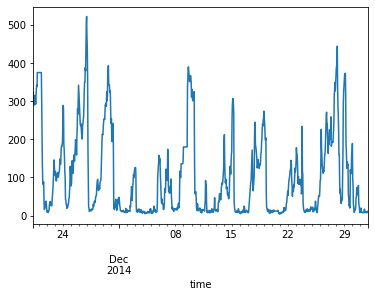

In [ ]:
data['pm2.5'][-1000:].plot()

<AxesSubplot:xlabel='time'>

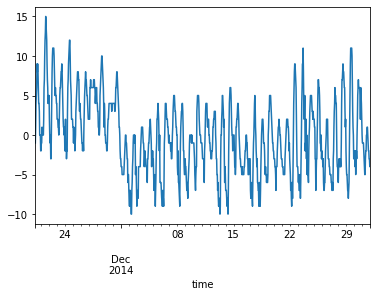

In [ ]:
data['temp'][-1000:].plot()

In [ ]:
data.head(3)

,pm2.5,dew,temp,press,iws,snow,rain,NE,NW,SE,cv
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0


In [ ]:
sequence_length = 5*24
delay = 24

In [ ]:
data_ = []
for i in range(len(data) - sequence_length - delay):
    data_.append(data.iloc[i: i + sequence_length + delay])

In [ ]:
data_ = np.array([df.values for df in data_])

In [ ]:
data_.shape

(43656, 144, 11)

In [ ]:
np.random.shuffle(data_)

In [ ]:
x = data_[:, :-delay, :]
y = data_[:, -1, 0]

In [ ]:
x = x.astype(np.float32)
y = y.astype(np.float32)

In [ ]:
split_boundary = int(data_.shape[0] * 0.8)

In [ ]:
train_x = x[: split_boundary]
test_x = x[split_boundary:]

train_y = y[: split_boundary]
test_y = y[split_boundary:]

In [ ]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((34924, 120, 11), (8732, 120, 11), (34924,), (8732,))

In [ ]:
mean = train_x.mean(axis=0)
std = train_x.std(axis=0)

In [ ]:
mean.shape

(120, 11)

In [ ]:
train_x = (train_x - mean)/std

In [ ]:
test_x = (test_x - mean)/std

In [ ]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return len(self.features)

In [ ]:
train_ds = Mydataset(train_x, train_y)
test_ds = Mydataset(test_x, test_y)

In [ ]:
BTACH_SIZE = 128

In [ ]:
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)

In [ ]:
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BTACH_SIZE
)

In [ ]:
hidden_size = 64

In [ ]:
class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(train_x.shape[-1], 
                           hidden_size, 
                           batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, inputs):
        _, s_o = self.rnn(inputs)
        s_o = s_o[-1]
        x = F.dropout(F.relu(self.fc1(s_o)))
        x = self.fc2(x)
        return torch.squeeze(x)

In [ ]:
model = Net(hidden_size)

In [ ]:
model

Net(
  (rnn): LSTM(11, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
if torch.cuda.is_available():
    model.to('cuda')

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def fit(epoch, model, trainloader, testloader):
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
        
        
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'test_loss： ', round(epoch_test_loss, 3),
             )
        
    return epoch_loss, epoch_test_loss

In [ ]:
epochs = 100

In [ ]:
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch,
                                      model,
                                      train_dl,
                                      test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

epoch:  0 loss：  23.613 test_loss：  25.115
epoch:  1 loss：  23.081 test_loss：  24.546
epoch:  2 loss：  22.261 test_loss：  23.605
epoch:  3 loss：  21.603 test_loss：  23.745
epoch:  4 loss：  21.623 test_loss：  24.013
epoch:  5 loss：  21.449 test_loss：  24.356
epoch:  6 loss：  21.052 test_loss：  22.461
epoch:  7 loss：  21.267 test_loss：  24.883
epoch:  8 loss：  21.083 test_loss：  21.641
epoch:  9 loss：  20.027 test_loss：  24.942
epoch:  10 loss：  19.944 test_loss：  20.995
epoch:  11 loss：  20.05 test_loss：  23.553
epoch:  12 loss：  30.013 test_loss：  29.03
epoch:  13 loss：  23.522 test_loss：  22.274
epoch:  14 loss：  20.181 test_loss：  21.099
epoch:  15 loss：  19.553 test_loss：  20.401
epoch:  16 loss：  18.925 test_loss：  21.033
epoch:  17 loss：  18.798 test_loss：  19.627
epoch:  18 loss：  19.772 test_loss：  20.952
epoch:  19 loss：  19.922 test_loss：  20.91
epoch:  20 loss：  19.068 test_loss：  20.825
epoch:  21 loss：  18.103 test_loss：  19.203
epoch:  22 loss：  19.176 test_loss：  20.891
e